In [74]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import plot_confusion_matrix,accuracy_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from xgboost import plot_importance
from matplotlib import pyplot

In [75]:
test_churn = pd.read_csv("/Users/ahmadzarzar/Downloads/csv_hämtade_filer/churn_test.csv")
train_churn = pd.read_csv("/Users/ahmadzarzar/Downloads/csv_hämtade_filer/churn_train.csv")

# Analysera datan

In [76]:
train_churn.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,1768-ZAIFU,Female,1,No,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,25.20,25.2,Yes
1,2159-TURXX,Male,0,No,No,5,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Credit card (automatic),20.05,95.55,No
2,8261-GWDBQ,Female,1,Yes,No,60,Yes,Yes,Fiber optic,Yes,...,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),116.05,6925.9,No
3,2732-ISEZX,Female,0,No,No,5,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Mailed check,20.50,104.3,No
4,7607-QKKTJ,Male,0,Yes,Yes,45,Yes,Yes,Fiber optic,No,...,Yes,No,No,Yes,One year,Yes,Credit card (automatic),95.00,4368.85,No


In [77]:
train_churn.tail()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
5629,9880-TDQAC,Female,0,Yes,Yes,72,No,No phone service,DSL,No,...,Yes,Yes,Yes,Yes,Two year,Yes,Electronic check,60.00,4264,No
5630,9030-QGZNL,Female,0,No,No,8,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.85,161.65,No
5631,2796-NNUFI,Female,0,Yes,Yes,46,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,Yes,Mailed check,19.95,927.1,No
5632,3521-SYVOR,Female,0,No,No,37,Yes,No,DSL,No,...,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,64.75,2345.2,Yes
5633,5453-AXEPF,Male,0,Yes,No,17,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Bank transfer (automatic),80.50,1336.9,No


In [96]:
test_churn.tail()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
1404,Male,0,No,No,25,Yes,No,Fiber optic,Yes,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,105.50,2686.05,0
1405,Female,0,Yes,Yes,45,No,No phone service,DSL,Yes,No,No,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),50.90,2333.85,0
1406,Male,0,No,No,10,Yes,No,DSL,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,45.55,402.60,1
1407,Male,0,Yes,Yes,38,Yes,Yes,DSL,No,Yes,Yes,No,Yes,Yes,One year,No,Credit card (automatic),78.95,2862.55,0
1408,Female,1,No,No,41,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,104.40,4133.95,0


In [78]:
train_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5634 entries, 0 to 5633
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        5634 non-null   object 
 1   gender            5634 non-null   object 
 2   SeniorCitizen     5634 non-null   int64  
 3   Partner           5634 non-null   object 
 4   Dependents        5634 non-null   object 
 5   tenure            5634 non-null   int64  
 6   PhoneService      5634 non-null   object 
 7   MultipleLines     5634 non-null   object 
 8   InternetService   5634 non-null   object 
 9   OnlineSecurity    5634 non-null   object 
 10  OnlineBackup      5634 non-null   object 
 11  DeviceProtection  5634 non-null   object 
 12  TechSupport       5634 non-null   object 
 13  StreamingTV       5634 non-null   object 
 14  StreamingMovies   5634 non-null   object 
 15  Contract          5634 non-null   object 
 16  PaperlessBilling  5634 non-null   object 


### Finns dubbletter?

In [79]:
print(f'***Train_churn***\n{train_churn.duplicated().value_counts()}')

***Train_churn***
False    5634
dtype: int64


### Saknas värden?

In [80]:
print(f'***Train_churn***\n{train_churn.isna().sum()}')

***Train_churn***
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


### Hur ser fördelningen av target datan ut? Är den jämt fördelad? Om inte, kan det ställa till med problem?

Customers who stayed:   4148
Customers who churned:   1486


Text(0, 0.5, 'Count')

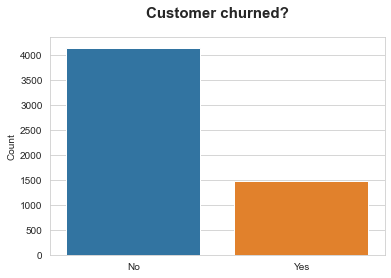

In [81]:
target_dist = train_churn['Churn'].value_counts()
print('Customers who stayed:  ', target_dist[0])
print('Customers who churned:  ', target_dist[1])


# Visualize the customer churn distribution
sns.set_style('whitegrid')
sns.barplot(x=target_dist.index, y=target_dist.values)
plt.title('Customer churned?', pad=20, fontsize=15, fontweight='bold')
plt.ylabel('Count')

Det är uppenbart att det inte jämt fördelad det är klassobalans i vår datauppsättning eftersom det är typ 26,5 % av kunderna churnade medan 73,5 % av kunderna stannade.
och frågan om det kan ställa till med problem, faktiskt ja eftersom beslutsträdsbaserade modeller som XGBoost är mottagliga för frekvens datapunkter, därför kan det ställa till med problem när fördelningen är inte lika.

# Förbered datan för att kunna användas av modellen

### Finns det data som ej borde användas? Varför i så fall?

Ja det finns eftersom det verkar som att TotalCharges bara består av strängar och där finns det tydligen elva tomma strängar totalt mellan testdata 3 och 8 i träningdata som inte kan omvandlas så därför valde jag att ersätta de med 0 istället och kommer att kunna omvandla den till en float.

In [82]:

train_churn['TotalCharges'] = train_churn.TotalCharges.replace({' ': 0})
train_churn['TotalCharges'] = pd.to_numeric(train_churn.TotalCharges, errors='coerce')


# remove the 9 rows with missing values
# print(train_churn.info())


train_churn = train_churn.drop('customerID', axis=1)

train_churn['Churn'] = train_churn.Churn.replace({'No': 0, 'Yes':1})





test_churn['TotalCharges'] = test_churn.TotalCharges.replace({' ': 0})
test_churn['TotalCharges'] = pd.to_numeric(test_churn.TotalCharges, errors='coerce')


# remove the 9 rows with missing values
# print(test_churn.info())


test_churn = test_churn.drop('customerID', axis=1)

test_churn['Churn'] = test_churn.Churn.replace({'No': 0, 'Yes':1})




x_train=train_churn.drop(columns=['Churn'])
y_train=train_churn.Churn

x_test =test_churn.drop(columns=['Churn'])
y_test= test_churn.Churn




In [83]:
# Function to check if a string can be converted to a float
def is_convertible(value):
    """
    Checks to see whether a string can be converted to a float.
    Input:
        - A string
    Output:
        - A boolean indicating whether or not the string can be converted to a float
    """
    try:
        float(value)
        return True
    except ValueError:
        return False

    
    
# Initialize list of strings that can't be converted to a float
unconvertibles = []

# Iterate through an array of strings, and append unconvertible strings to a list
str_array = train_churn['TotalCharges'].to_numpy()
for element in str_array:
    if is_convertible(element) == False:
        unconvertibles.append(element)

# See which strings (if any) are unconvertible
print("Unconvertibles:  ", unconvertibles)
print("Count of unconvertibles:  ", len(unconvertibles))

Unconvertibles:   []
Count of unconvertibles:   0


In [84]:
train_churn.nunique()

gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1499
TotalCharges        5290
Churn                  2
dtype: int64

### Det finns en hel del textdata som måste behandlas på något vis (finns flera olika alternativ)

In [85]:
# generate the list of categorical and numerical variables
categorical_variables = train_churn.nunique()[train_churn.nunique() < 5].keys().to_list()

numerical_variables=list(set(train_churn.columns) - set(categorical_variables))
categorical_variables.remove('Churn')
############################################
categorical_variables = test_churn.nunique()[test_churn.nunique() < 5].keys().to_list()

numerical_variables=list(set(test_churn.columns) - set(categorical_variables))
categorical_variables.remove('Churn')

ohe = OneHotEncoder(drop='first', sparse=False)

X_train_ohe = ohe.fit_transform(x_train[categorical_variables])
X_train_ohe_df = pd.DataFrame(X_train_ohe, columns=ohe.get_feature_names(categorical_variables))

# Transform only without fitting
X_test_ohe = ohe.transform(x_test[categorical_variables])
X_test_ohe_df = pd.DataFrame(X_test_ohe, columns=ohe.get_feature_names(categorical_variables))


scaler = StandardScaler()
X_train_sc = scaler.fit_transform(x_train[numerical_variables])
X_train_sc_df = pd.DataFrame(X_train_sc, columns=numerical_variables)

# Transform only without fitting
X_test_sc = scaler.transform(x_test[numerical_variables])
X_test_sc_df = pd.DataFrame(X_test_sc, columns=numerical_variables)

# Merging the transformed dataframe togheter
x_train = pd.merge(X_train_ohe_df, X_train_sc_df, left_index=True, right_index=True)
x_test = pd.merge(X_test_ohe_df, X_test_sc_df, left_index=True, right_index=True)

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


In [86]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5634 entries, 0 to 5633
Data columns (total 30 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   gender_Male                            5634 non-null   float64
 1   SeniorCitizen_1                        5634 non-null   float64
 2   Partner_Yes                            5634 non-null   float64
 3   Dependents_Yes                         5634 non-null   float64
 4   PhoneService_Yes                       5634 non-null   float64
 5   MultipleLines_No phone service         5634 non-null   float64
 6   MultipleLines_Yes                      5634 non-null   float64
 7   InternetService_Fiber optic            5634 non-null   float64
 8   InternetService_No                     5634 non-null   float64
 9   OnlineSecurity_No internet service     5634 non-null   float64
 10  OnlineSecurity_Yes                     5634 non-null   float64
 11  Onli

# Tränar en XGBoost modell

In [87]:

model = xgb.XGBClassifier(learning_rate=0.1,n_estimators=30,reg_alpha=5, reg_lambda=5, max_delta_step=10,min_child_weight=1)
model.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=10, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=30, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=5, reg_lambda=5, ...)

#  Utvärderar modellen

In [88]:
accuracy=model.score(x_test,y_test)
pred=model.predict(x_test)
print(f'totalt accuracy är {accuracy}')
print(f'totalt accuracy är {accuracy_score(y_test,pred)*100} * 100')

totalt accuracy är 0.801277501774308
totalt accuracy är 80.1277501774308 * 100


## Analysera vilka attribut som har störst påverkan

<AxesSubplot:>

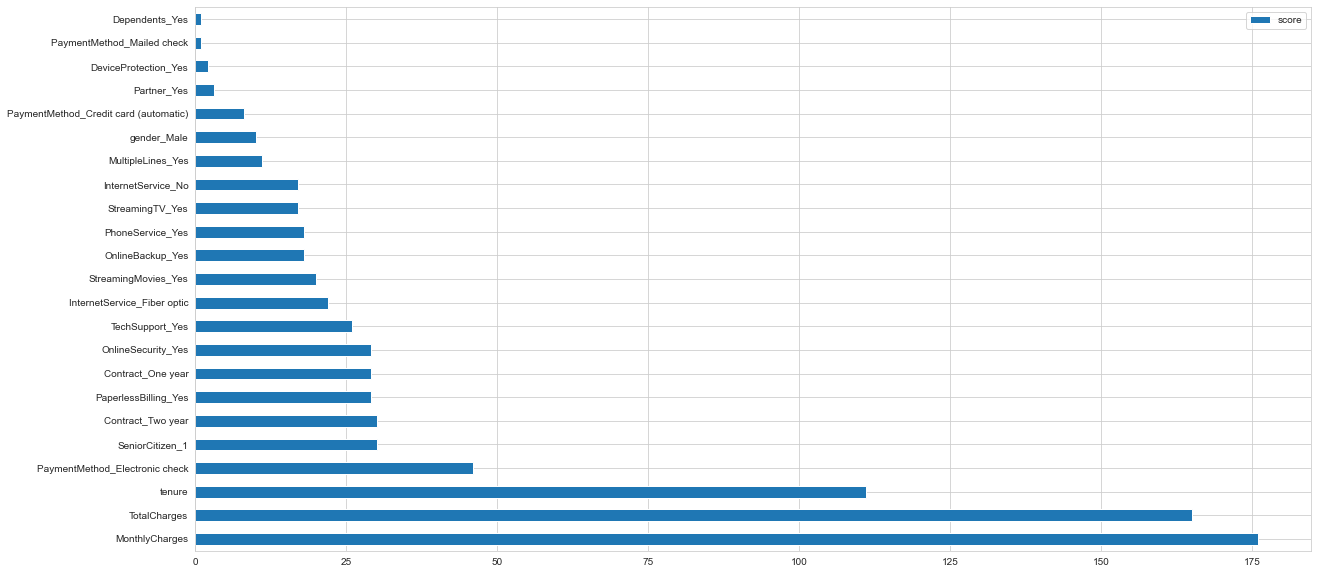

In [95]:
feature_important = model.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(40, columns="score").plot(kind='barh', figsize = (20,10)) ## plot top 40 features

In [105]:
print(feature_important)

{'gender_Male': 10.0, 'SeniorCitizen_1': 30.0, 'Partner_Yes': 3.0, 'Dependents_Yes': 1.0, 'PhoneService_Yes': 18.0, 'MultipleLines_Yes': 11.0, 'InternetService_Fiber optic': 22.0, 'InternetService_No': 17.0, 'OnlineSecurity_Yes': 29.0, 'OnlineBackup_Yes': 18.0, 'DeviceProtection_Yes': 2.0, 'TechSupport_Yes': 26.0, 'StreamingTV_Yes': 17.0, 'StreamingMovies_Yes': 20.0, 'Contract_One year': 29.0, 'Contract_Two year': 30.0, 'PaperlessBilling_Yes': 29.0, 'PaymentMethod_Credit card (automatic)': 8.0, 'PaymentMethod_Electronic check': 46.0, 'PaymentMethod_Mailed check': 1.0, 'MonthlyCharges': 176.0, 'tenure': 111.0, 'TotalCharges': 165.0}


När vi tittar på den här grafen kan vi se att modellen XGBoost har attribut som har störst påverkan på denna modellen och den som kommer i det stora påverkan är MonthlyCharges och efter kommer TotalCharges ocg sedan tenure osv som ni ser i grafen den fortsätter i score till den sista attribut.

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


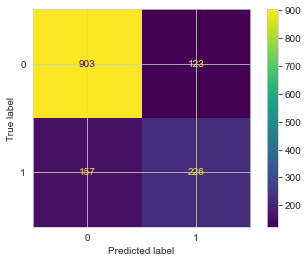

In [94]:
plot_confusion_matrix(model, x_test, y_test)  
plt.show()

Som vi ser när vi har tränat vår modell och när  så får vi i testscore 0.80  vilket är ganska bra men modellen har ändå svårt att klassificera några klasser så om vi kollar på 1 i predicted label axeln så kolla vi uppåt så ser vi att den gissade 123 gånger på 0 och  när den var 0 i predicted label axeln istellet så hittar vi att den predictade 157 gånger på 1 när den var 0 så det är inte så mycket i andelen men den har ändå svårt för 28% av klasser att klassificera. 